In [164]:
"""
Utilidades para cargar y procesar el dataset WiFi UAB
======================================================

Este módulo proporciona funciones auxiliares para facilitar
la carga y exploración del dataset WiFi de la UAB.

Autor: Albert Gil López
"""

import json
import pandas as pd
from pathlib import Path
from typing import List, Optional, Union
from datetime import datetime
import warnings
import re
warnings.filterwarnings('ignore')


def load_json_file(file_path: Union[str, Path]) -> List[dict]:
    """
    Carga un archivo JSON y retorna la lista de registros.

    Args:
        file_path: Ruta al archivo JSON

    Returns:
        Lista de diccionarios con los registros
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)


def load_multiple_files(
    directory: Union[str, Path],
    pattern: str = "*.json",
    max_files: Optional[int] = None,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Carga múltiples archivos JSON de un directorio y los combina en un DataFrame.

    Args:
        directory: Directorio con los archivos JSON
        pattern: Patrón de archivos a buscar (default: "*.json")
        max_files: Número máximo de archivos a cargar (None = todos)
        verbose: Mostrar progreso de carga

    Returns:
        DataFrame de pandas con todos los registros combinados

    Ejemplo:
        >>> df = load_multiple_files("anonymized_data/aps", max_files=10)
        >>> print(f"Cargados {len(df)} registros")
    """
    directory = Path(directory)
    files = sorted(directory.glob(pattern))

    if max_files:
        files = files[:max_files]

    if verbose:
        print(f"📁 Encontrados {len(files)} archivos en {directory}")
        print(f"📊 Cargando {'todos' if not max_files else max_files} archivos...")

    all_records = []
    for i, file in enumerate(files):
        try:
            records = load_json_file(file)
            all_records.extend(records)

            if verbose and (i + 1) % 10 == 0:
                print(f"   Procesados {i + 1}/{len(files)} archivos... ({len(all_records)} registros)")
        except Exception as e:
            print(f"⚠️  Error en {file.name}: {e}")
            continue

    df = pd.DataFrame(all_records)

    if verbose:
        print(f"✅ Cargados {len(df)} registros de {len(files)} archivos")
        print(f"💾 Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    return df


def load_aps(
    data_dir: Union[str, Path] = "../anonymized_data/aps",
    coords_file: Union[str, Path, None] = "./data/geo.json",
    max_files: Optional[int] = 10,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Load and combine multiple Access Point (AP) JSON files,
    extracting timestamps from filenames and merging with
    coordinate data from a GeoJSON file.

    Args:
        data_dir: Directory containing AP JSON files.
        coords_file: GeoJSON file with AP coordinates.
        max_files: Max number of files to load (None = all).
        verbose: Print progress info.

    Returns:
        DataFrame with columns like:
        ['timestamp', 'macaddr', 'name', 'client_count', 'x', 'y', ...]
    """
    data_dir = Path(data_dir)
    json_files = sorted(data_dir.glob("AP-info-v2-*.json"))
    if max_files:
        json_files = json_files[:max_files]

    if verbose:
        print(f"📁 Loading {len(json_files)} files from '{data_dir}'")

    timestamp_pattern = re.compile(r"AP-info-v2-(.+)\.json")
    records = []

    # --- 1️⃣ Load AP JSON files ---
    for file in json_files:
        match = timestamp_pattern.search(file.name)
        if not match:
            continue

        ts_raw = match.group(1)
        s_clean = ts_raw.split('+')[0]  # ignore timezone
        timestamp = pd.to_datetime(s_clean, format="%Y-%m-%dT%H_%M_%S")

        with open(file, "r") as f:
            aps_data = json.load(f)

        for ap in aps_data:
            records.append({
                "timestamp": timestamp,
                "macaddr": ap.get("macaddr"),
                "name": ap.get("name"),
                "client_count": ap.get("client_count", 0),
                "site": ap.get("site"),
                "group_name": ap.get("group_name"),
                "model": ap.get("model"),
                "status": ap.get("status"),
                "firmware_version": ap.get("firmware_version"),
            })

        if verbose:
            print(f"✅ {file.name}: {len(aps_data)} APs loaded")

    df = pd.DataFrame(records)
    if df.empty:
        print("⚠️ No records found in the selected files.")
        return df

    df = df.sort_values(["macaddr", "timestamp"]).reset_index(drop=True)

    # --- 2️⃣ Load and merge coordinate data ---
    if coords_file and Path(coords_file).exists():
        if verbose:
            print(f"🌍 Loading coordinates from '{coords_file}'")

        with open(coords_file, "r") as f:
            coords_json = json.load(f)

        coords_list = []
        for feature in coords_json.get("features", []):
            props = feature.get("properties", {})
            coords_list.append({
                "name": props.get("USER_NOM_A"),
                "x": props.get("X"),
                "y": props.get("Y"),
                "plant": props.get("USER_PLANT")
            })

        coords_df = pd.DataFrame(coords_list)

        # Normalize names to match
        df["name_norm"] = df["name"].str.strip().str.upper()
        coords_df["name_norm"] = coords_df["name"].str.strip().str.upper()

        df = df.merge(coords_df[["name_norm", "x", "y", "plant"]], on="name_norm", how="left")
        df.drop(columns=["name_norm"], inplace=True)
        if verbose:
            missing = df["x"].isna().sum()
            print(f"📍 Coordinates assigned: {len(df) - missing:,} / {len(df):,}")
    else:
        if verbose:
            print("⚠️ Coordinate file not found or not provided.")

    if verbose:
        print(f"\n🎯 Total records: {len(df):,}")
        print(f"📡 Unique APs: {df['macaddr'].nunique():,}")

    return df
def load_clients(
    data_dir: Union[str, Path] = "../anonymized_data/clients",
    max_files: Optional[int] = 10,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Carga archivos de Clientes/Dispositivos.

    Args:
        data_dir: Directorio con archivos de clientes
        max_files: Número máximo de archivos (None = todos)
        verbose: Mostrar progreso

    Returns:
        DataFrame con datos de clientes
    """
    df = load_multiple_files(data_dir, max_files=max_files, verbose=verbose)

    # Convertir timestamp a datetime
    if 'last_connection_time' in df.columns:
        df['last_connection_time'] = pd.to_numeric(df['last_connection_time'], errors='coerce').astype('Int64')
        df['timestamp'] = pd.to_datetime(df['last_connection_time'], unit='ms')
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.day_name()
        df['date'] = df['timestamp'].dt.date
    print(df['date'][0])
    return df


def get_dataset_info(df: pd.DataFrame) -> dict:
    """
    Retorna información básica del DataFrame.

    Args:
        df: DataFrame a analizar

    Returns:
        Diccionario con información del dataset
    """
    info = {
        'total_records': len(df),
        'memory_mb': df.memory_usage(deep=True).sum() / 1024**2,
        'columns': list(df.columns),
        'null_counts': df.isnull().sum().to_dict(),
        'dtypes': df.dtypes.to_dict()
    }

    if 'timestamp' in df.columns:
        info['date_range'] = {
            'start': df['timestamp'].min(),
            'end': df['timestamp'].max(),
            'days': (df['timestamp'].max() - df['timestamp'].min()).days
        }

    return info


def print_dataset_summary(df: pd.DataFrame, name: str = "Dataset"):
    """
    Imprime un resumen legible del dataset.

    Args:
        df: DataFrame a resumir
        name: Nombre del dataset
    """
    print(f"\n{'='*60}")
    print(f"📊 RESUMEN: {name}")
    print(f"{'='*60}")

    print(f"\n🔢 Registros totales: {len(df):,}")
    print(f"📝 Columnas: {len(df.columns)}")
    print(f"💾 Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    if 'timestamp' in df.columns:
        print(f"\n📅 Rango temporal:")
        print(f"   Inicio: {df['timestamp'].min()}")
        print(f"   Fin:    {df['timestamp'].max()}")
        print(f"   Días:   {(df['timestamp'].max() - df['timestamp'].min()).days}")

    print(f"\n📋 Columnas disponibles:")
    for col in df.columns[:10]:
        non_null = df[col].notna().sum()
        pct = (non_null / len(df)) * 100
        print(f"   • {col:30s} ({pct:5.1f}% completo)")

    if len(df.columns) > 10:
        print(f"   ... y {len(df.columns) - 10} columnas más")

    print(f"\n{'='*60}\n")


def get_top_aps(df_clients: pd.DataFrame, top_n: int = 10) -> pd.DataFrame:
    """
    Retorna los APs más utilizados.

    Args:
        df_clients: DataFrame de clientes
        top_n: Número de APs a retornar

    Returns:
        DataFrame con los top APs y número de conexiones
    """
    return (df_clients['associated_device_name']
            .value_counts()
            .head(top_n)
            .reset_index()
            .rename(columns={'index': 'AP', 'associated_device_name': 'connections'}))


def filter_by_time(
    df: pd.DataFrame,
    start_time: Optional[str] = None,
    end_time: Optional[str] = None,
    hour_range: Optional[tuple] = None
) -> pd.DataFrame:
    """
    Filtra registros por tiempo.

    Args:
        df: DataFrame con columna 'timestamp'
        start_time: Fecha/hora inicio (formato: "2025-04-03")
        end_time: Fecha/hora fin
        hour_range: Tupla (hora_inicio, hora_fin) ej: (8, 18) para 8am-6pm

    Returns:
        DataFrame filtrado
    """
    result = df.copy()

    if start_time:
        result = result[result['timestamp'] >= pd.to_datetime(start_time)]

    if end_time:
        result = result[result['timestamp'] <= pd.to_datetime(end_time)]

    if hour_range:
        start_hour, end_hour = hour_range
        result = result[
            (result['timestamp'].dt.hour >= start_hour) &
            (result['timestamp'].dt.hour < end_hour)
        ]

    return result


def get_device_history(
    df: pd.DataFrame,
    device_id: str,
    sort_by_time: bool = True
) -> pd.DataFrame:
    """
    Obtiene el historial completo de un dispositivo.

    Args:
        df: DataFrame de clientes
        device_id: ID del dispositivo (ej: "CLIENT_87e3ddea248c")
        sort_by_time: Ordenar por timestamp

    Returns:
        DataFrame con historial del dispositivo
    """
    history = df[df['macaddr'] == device_id].copy()

    if sort_by_time and 'timestamp' in history.columns:
        history = history.sort_values('timestamp')

    return history


def calculate_signal_quality_stats(df_clients: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula estadísticas de calidad de señal por AP.

    Args:
        df_clients: DataFrame de clientes

    Returns:
        DataFrame con estadísticas por AP
    """
    return (df_clients.groupby('associated_device_name')
            .agg({
                'signal_db': ['mean', 'std', 'min', 'max'],
                'signal_strength': 'mean',
                'snr': 'mean',
                'speed': 'mean',
                'macaddr': 'count'
            })
            .round(2)
            .rename(columns={'macaddr': 'total_connections'}))


def get_hourly_activity(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcula actividad por hora del día.

    Args:
        df: DataFrame con columna 'timestamp'

    Returns:
        DataFrame con conteo por hora
    """
    if 'hour' not in df.columns and 'timestamp' in df.columns:
        df['hour'] = df['timestamp'].dt.hour

    return (df.groupby('hour')
            .size()
            .reset_index(name='count')
            .sort_values('hour'))


# Constantes útiles
AP_NAME_PATTERN = r'AP-([A-Z]+)(\d+)'  # Patrón para extraer edificio del nombre

SIGNAL_STRENGTH_LABELS = {
    1: 'Muy Mala',
    2: 'Mala',
    3: 'Regular',
    4: 'Buena',
    5: 'Excelente'
}

NETWORK_TYPES = ['UAB', 'eduroam']

BANDS = {
    2.4: '2.4 GHz',
    5: '5 GHz',
    6: '6 GHz'
}


if __name__ == "__main__":
    # Ejemplo de uso
    print("🧪 Testing data_loader.py...")
    print("\nEste módulo proporciona utilidades para cargar el dataset.")
    print("Importa las funciones en tu notebook con:")
    print("  from utils.data_loader import load_aps, load_clients")

🧪 Testing data_loader.py...

Este módulo proporciona utilidades para cargar el dataset.
Importa las funciones en tu notebook con:
  from utils.data_loader import load_aps, load_clients


# 🏴‍☠️ UAB THE HACK! 2025 - WiFi Dataset Analysis
## Nivel 1: ROOKIE - Análisis Básico

**Objetivo:** Explorar y visualizar el dataset de WiFi de la UAB

**Dataset:**
- Access Points (APs): 2,333 archivos con snapshots de APs del campus
- Clientes: 3,199 archivos con dispositivos conectados
- Período: Abril-Julio 2025

---

## 📦 1. Importar Librerías

Primero, importamos las librerías necesarias para el análisis.

In [115]:
# Librerías estándar y científicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Configuración general
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 18,
    "axes.labelsize": 14
})

# Carga de funciones personalizadas
#from utils.data_loader import (
#    load_aps,
#    load_clients,
#    print_dataset_summary,
#    get_top_aps
#)

print("✅ Librerías y utilidades cargadas correctamente")

✅ Librerías y utilidades cargadas correctamente


## 📂 2. Cargar Datos

Cargamos una muestra del dataset. Empezaremos con 10 archivos para exploración rápida.

**Nota:** Para cargar TODO el dataset, cambia `max_files=None`

In [ ]:
# Cargar Access Points (primeros 10 archivos)
df_aps = load_aps(
    data_dir="./data/aps",
    max_files=10000,
    verbose=True
)

print("\n" + "="*60)
print(f"🎯 APs cargados: {len(df_aps):,} registros")
print("="*60)

📁 Loading 10 files from 'data\aps'
✅ AP-info-v2-2025-04-03T00_00_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T00_15_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T00_30_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T00_45_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T01_00_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T01_15_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T01_30_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T01_45_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T02_00_01+02_00.json: 1128 APs loaded
✅ AP-info-v2-2025-04-03T02_15_01+02_00.json: 1128 APs loaded
🌍 Loading coordinates from './data/geo.json'
📍 Coordinates assigned: 18,430 / 20,500

🎯 Total records: 20,500
📡 Unique APs: 1,128

🎯 APs cargados: 20,500 registros


In [166]:
# --- 2️⃣ Crear carpeta de salida ---
output_dir = Path("./data/aps_by_mac")
output_dir.mkdir(parents=True, exist_ok=True)


# --- 3️⃣ Verificar columnas necesarias ---
required_cols = {"macaddr", "timestamp", "client_count", "x", "y", "plant"}
if not required_cols.issubset(df_aps.columns):
    missing = required_cols - set(df_aps.columns)
    print(f"❌ Faltan columnas necesarias en df_aps: {missing}")

# --- 4️⃣ Seleccionar columnas relevantes ---
df_connections = df_aps[["macaddr", "timestamp", "client_count", "x", "y", "plant"]].copy()

# Eliminar posibles valores nulos
df_connections = df_connections.dropna(subset=["macaddr", "timestamp"])


# --- 5️⃣ Agrupar por macaddr y exportar ---
for mac, group in df_connections.groupby("macaddr"):
    group_sorted = group.sort_values("timestamp")

    # Crear nombre de archivo seguro
    safe_mac = mac.replace(":", "").replace("AP_", "").replace("-", "_")
    file_path = output_dir / f"{safe_mac}.csv"

    # Exportar a CSV
    group_sorted.to_csv(file_path, index=False)

    print(f"✅ Archivo creado: {file_path.name} ({len(group_sorted)} registros)")


# --- 6️⃣ Resumen ---
print(f"\n🎯 Total de APs exportados: {df_connections['macaddr'].nunique()}")
print(f"📂 Archivos guardados en: {output_dir.resolve()}")

✅ Archivo creado: 0009261244fd.csv (10 registros)
✅ Archivo creado: 002a7e027e98.csv (20 registros)
✅ Archivo creado: 00b9c754f69a.csv (20 registros)
✅ Archivo creado: 01736ee37b92.csv (20 registros)
✅ Archivo creado: 01eaee869b2a.csv (20 registros)
✅ Archivo creado: 0262c72e744e.csv (20 registros)
✅ Archivo creado: 02b001548a26.csv (20 registros)
✅ Archivo creado: 0320ec998980.csv (20 registros)
✅ Archivo creado: 038a4f274f83.csv (20 registros)
✅ Archivo creado: 03b09fc7c87c.csv (20 registros)
✅ Archivo creado: 03ed27cba23d.csv (20 registros)
✅ Archivo creado: 040b55ee54a4.csv (20 registros)
✅ Archivo creado: 04a7c19cfde8.csv (20 registros)
✅ Archivo creado: 04bfc16d206e.csv (20 registros)
✅ Archivo creado: 056f5188f266.csv (20 registros)
✅ Archivo creado: 06023a5eabde.csv (10 registros)
✅ Archivo creado: 06058692e8a4.csv (10 registros)
✅ Archivo creado: 066ff8823144.csv (10 registros)
✅ Archivo creado: 069cd79b7e7c.csv (20 registros)
✅ Archivo creado: 06ae35b962fe.csv (20 registros)


## 🔍 3. Exploración Inicial

Veamos qué información tenemos disponible.

In [8]:
# Ver primeras filas de APs
print("📡 MUESTRA DE ACCESS POINTS:")
df_aps.head()

📡 MUESTRA DE ACCESS POINTS:


ap_deployment_mode ap_group  client_count cluster_id controller_name  \
0                IAP     None             2                              
1                IAP     None             9                              
2                IAP     None             3                              
3                IAP     None             0                              
4                IAP     None             0                              

   cpu_utilization firmware_version gateway_cluster_id gateway_cluster_name  \
0                5   10.6.0.3_90581                 82       auto_group_229   
1                7   10.6.0.3_90581                 82       auto_group_229   
2                5   10.6.0.3_90581                 82       auto_group_229   
3                4   10.6.0.3_90581                 82       auto_group_229   
4                4   10.6.0.3_90581                                           

   group_name  ...           serial site  sleep_status status    subnet_mask  \
0  Bellaterra  ...  AP_ea4f8dd0b2e0  UAB         False     Up  255.255.248.0   
1  Bellaterra  ...  AP_e5c7d5048a2f  UAB         False     Up  255.255.252.0   
2  Bellaterra  ...  AP_bb7eae2933c9  UAB         False     Up  255.255.224.0   
3  Bellaterra  ...  AP_b1da6b0a4503  UAB         False     Up  255.255.255.0   
4  Bellaterra  ...  AP_15316f125c98  UAB         False     Up  255.255.248.0   

   swarm_id swarm_master      swarm_name    uptime           timestamp  
0                  False        AP-VET71   8666128 2025-01-21 09:41:31  
1                  False  AP-EXTBIBHUM01   5754534 2025-01-26 07:36:20  
2                  False       AP-LLET32  11697044 2025-04-02 09:56:41  
3                  False       AP-GTIP12   1124429 2025-04-02 09:57:02  
4                  False       AP-DRET14    110841 2025-04-01 15:17:14  

[5 rows x 32 columns]

In [116]:
# Ver primeras filas de Clientes
print("📱 MUESTRA DE CLIENTES:")
df_clients.head()

📱 MUESTRA DE CLIENTES:


associated_device associated_device_mac associated_device_name  \
0   AP_8e2d9933ec92       AP_5cdc80c05afc              AP-CEDU26   
1   AP_f6e291deb8b9       AP_b509bd7bc558               AP-VET49   
2   AP_875979a461af       AP_e8c7358799e2              AP-LLET39   
3   AP_332aab2f3da0       AP_35f1fd725406            AP-SAB-S239   
4   AP_332aab2f3da0       AP_35f1fd725406            AP-SAB-S239   

  authentication_type  band       channel client_category client_type  \
0  MAC Authentication   5.0  100 (20 MHz)     SmartDevice    WIRELESS   
1  MAC Authentication   2.4    1 (20 MHz)        Computer    WIRELESS   
2  MAC Authentication   2.4    1 (20 MHz)        Computer    WIRELESS   
3  MAC Authentication   5.0   44 (20 MHz)     SmartDevice    WIRELESS   
4  MAC Authentication   5.0   44 (20 MHz)     SmartDevice    WIRELESS   

  connected_device_type                  connection  ... swarm_id  \
0                    AP           802.11ac, 802.11v  ...            
1                    AP                         NaN  ...            
2                    AP  802.11gn, 802.11k, 802.11v  ...      NaN   
3                    AP  802.11ac, 802.11k, 802.11v  ...            
4                    AP  802.11ac, 802.11k, 802.11v  ...            

          user_role           username    vlan usage  failure_reason  \
0               UAB  USER_87e3ddea248c  VLAN_A   NaN             NaN   
1  conv_authenticad  USER_94894477ff4b  VLAN_A   NaN             NaN   
2  conv_authenticad  USER_b3ed96b2b8f7  VLAN_A   NaN             NaN   
3  conv_authenticad  USER_744af19bbca3  VLAN_A   NaN             NaN   
4  conv_authenticad  USER_96645ec9c9d2  VLAN_A   NaN             NaN   

                timestamp  hour day_of_week        date  
0 2025-04-02 09:56:27.000   9.0   Wednesday  2025-04-02  
1 2025-04-02 19:52:24.927  19.0   Wednesday  2025-04-02  
2 2025-04-02 14:06:38.628  14.0   Wednesday  2025-04-02  
3 2025-04-02 03:05:49.183   3.0   Wednesday  2025-04-02  
4 2025-03-28 13:29:39.000  13.0      Friday  2025-03-28  

[5 rows x 46 columns]

In [9]:
# Información del dataset de APs
print_dataset_summary(df_aps, "Access Points")


📊 RESUMEN: Access Points

🔢 Registros totales: 11,280
📝 Columnas: 32
💾 Memoria: 14.75 MB

📅 Rango temporal:
   Inicio: 2025-01-21 09:34:51
   Fin:    2025-04-03 00:05:47
   Días:   71

📋 Columnas disponibles:
   • ap_deployment_mode             (100.0% completo)
   • ap_group                       ( 26.1% completo)
   • client_count                   (100.0% completo)
   • cluster_id                     (100.0% completo)
   • controller_name                (100.0% completo)
   • cpu_utilization                (100.0% completo)
   • firmware_version               (100.0% completo)
   • gateway_cluster_id             (100.0% completo)
   • gateway_cluster_name           (100.0% completo)
   • group_name                     (100.0% completo)
   ... y 22 columnas más




In [118]:
# Información del dataset de Clientes
print_dataset_summary(df_clients, "Clientes")


📊 RESUMEN: Clientes

🔢 Registros totales: 11,519
📝 Columnas: 46
💾 Memoria: 21.87 MB

📅 Rango temporal:
   Inicio: 2025-03-28 12:08:19.808000
   Fin:    2025-04-03 06:15:31
   Días:   5

📋 Columnas disponibles:
   • associated_device              (100.0% completo)
   • associated_device_mac          (100.0% completo)
   • associated_device_name         (100.0% completo)
   • authentication_type            ( 97.3% completo)
   • band                           ( 95.6% completo)
   • channel                        ( 95.6% completo)
   • client_category                ( 96.5% completo)
   • client_type                    (100.0% completo)
   • connected_device_type          (100.0% completo)
   • connection                     ( 93.7% completo)
   ... y 36 columnas más




## 📊 4. Estadísticas Básicas

### 4.1 Access Points

In [10]:
# Número de APs únicos
unique_aps = df_aps['name'].nunique()
print(f"📡 APs únicos en el campus: {unique_aps}")

# Estado de los APs
print("\n🔌 Estado de los APs:")
print(df_aps['status'].value_counts())

# APs más populares (por número de clientes)
print("\n👥 Top 10 APs por número de clientes conectados:")
top_aps = df_aps.nlargest(10, 'client_count')[['name', 'client_count', 'status']]
print(top_aps)

📡 APs únicos en el campus: 1128

🔌 Estado de los APs:
status
Up    11280
Name: count, dtype: int64

👥 Top 10 APs por número de clientes conectados:
            name  client_count status
3469   AP-CCOM34            18     Up
4597   AP-CCOM34            18     Up
5725   AP-CCOM34            18     Up
6853   AP-CCOM34            18     Up
7981   AP-CCOM34            18     Up
9109   AP-CCOM34            18     Up
10237  AP-CCOM34            18     Up
85     AP-CCOM34            17     Up
1213   AP-CCOM34            17     Up
2341   AP-CCOM34            17     Up


### 4.2 Clientes/Dispositivos

In [120]:
# Dispositivos únicos
unique_devices = df_clients['macaddr'].nunique()
print(f"📱 Dispositivos únicos: {unique_devices:,}")

# Tipos de red
print("\n🌐 Distribución por tipo de red:")
print(df_clients['network'].value_counts())

# Sistemas operativos
print("\n💻 Top 10 sistemas operativos:")
print(df_clients['os_type'].value_counts().head(10))

# Categorías de dispositivos
print("\n📦 Categorías de dispositivos:")
print(df_clients['client_category'].value_counts())

📱 Dispositivos únicos: 3,803

🌐 Distribución por tipo de red:
network
UAB        7728
eduroam    3429
IdC         328
IdC5GHz      30
Name: count, dtype: int64

💻 Top 10 sistemas operativos:
os_type
Apple iOS Device           2760
Android                    2393
Windows 8/10/11            1970
Mac OS                     1156
Samsung Android             454
Apple iPhone                384
--                          350
Windows                     305
HP Printer                  257
Chromecast Media Player     240
Name: count, dtype: int64

📦 Categorías de dispositivos:
client_category
SmartDevice                   6398
Computer                      3584
Home Audio/Video Equipment     525
Printer                        307
IoT                            180
Generic                         32
Game Console                    25
Lighting                        20
Monitoring Devices              18
Embedded                        16
Router                           8
Name: count, dtype: int

## 📈 5. Visualizaciones Básicas

### 5.1 Zonas "Hotspot" - APs más utilizados

In [4]:
# Top 15 APs más utilizados
top_aps_usage = df_clients['associated_device_name'].value_counts().head(15)
plt.figure(figsize=(12, 6))
top_aps_usage.plot(kind='barh', color='steelblue')
plt.title('📡 Top 15 Access Points Más Utilizados', fontsize=16, fontweight='bold')
plt.xlabel('Número de Conexiones', fontsize=12)
plt.ylabel('Access Point', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🔥 El AP más usado es: {top_aps_usage.index[0]} con {top_aps_usage.values[0]:,} conexiones")

NameError: name 'df_clients' is not defined

### 5.2 Patrones Temporales - Actividad por Hora

In [122]:
# Actividad por hora del día
hourly_activity = df_clients.groupby('hour').size()

plt.figure(figsize=(14, 6))
plt.plot(hourly_activity.index, hourly_activity.values, marker='o', linewidth=2, markersize=8, color='coral')
plt.fill_between(hourly_activity.index, hourly_activity.values, alpha=0.3, color='coral')
plt.title('⏰ Dispositivos Conectados por Hora del Día', fontsize=16, fontweight='bold')
plt.xlabel('Hora del Día (0-23)', fontsize=12)
plt.ylabel('Número de Dispositivos', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Identificar hora pico
peak_hour = hourly_activity.idxmax()
peak_devices = hourly_activity.max()
print(f"\n🕐 Hora pico: {peak_hour}:00 con {peak_devices:,} dispositivos conectados")


🕐 Hora pico: 9.0:00 con 2,109 dispositivos conectados


### 5.3 Distribución de Calidad de Señal

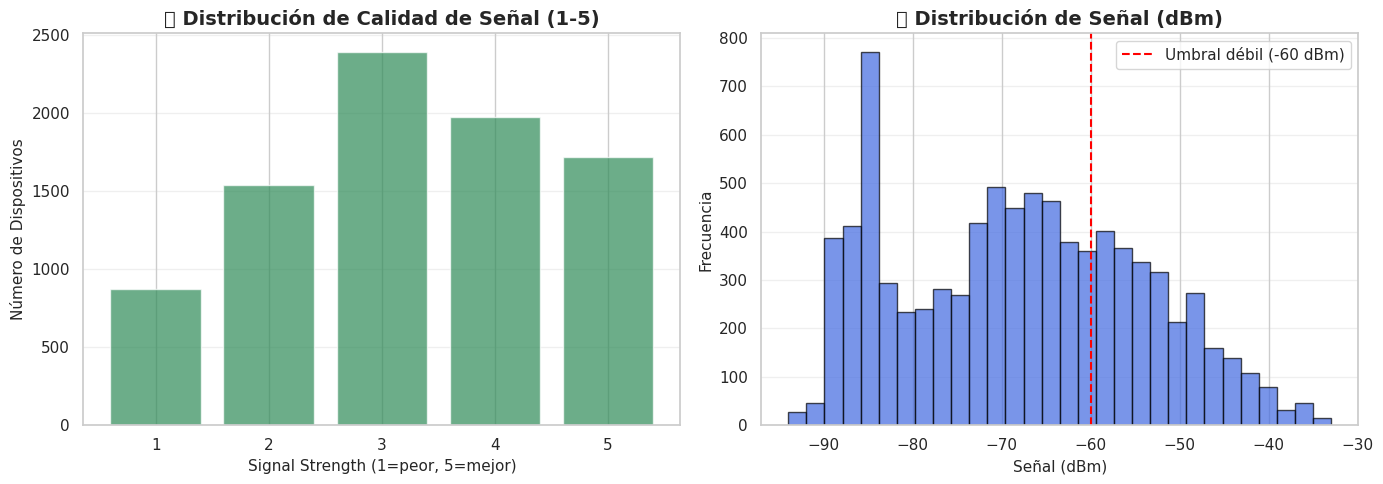


📡 Señal promedio: -67.9 dBm
⚠️  Dispositivos con señal débil (<-60 dBm): 5,821 (50.5%)


In [123]:
# Distribución de signal_strength (1-5)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Signal Strength (1-5)
signal_counts = df_clients['signal_strength'].value_counts().sort_index()
axes[0].bar(signal_counts.index, signal_counts.values, color='seagreen', alpha=0.7)
axes[0].set_title('📶 Distribución de Calidad de Señal (1-5)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Signal Strength (1=peor, 5=mejor)', fontsize=11)
axes[0].set_ylabel('Número de Dispositivos', fontsize=11)
axes[0].set_xticks([1, 2, 3, 4, 5])
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Signal dB (histograma)
axes[1].hist(df_clients['signal_db'].dropna(), bins=30, color='royalblue', alpha=0.7, edgecolor='black')
axes[1].set_title('📊 Distribución de Señal (dBm)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Señal (dBm)', fontsize=11)
axes[1].set_ylabel('Frecuencia', fontsize=11)
axes[1].axvline(x=-60, color='red', linestyle='--', label='Umbral débil (-60 dBm)')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas
avg_signal = df_clients['signal_db'].mean()
weak_signal = (df_clients['signal_db'] < -60).sum()
pct_weak = (weak_signal / len(df_clients)) * 100

print(f"\n📡 Señal promedio: {avg_signal:.1f} dBm")
print(f"⚠️  Dispositivos con señal débil (<-60 dBm): {weak_signal:,} ({pct_weak:.1f}%)")

### 5.4 Tipos de Red (UAB vs eduroam)

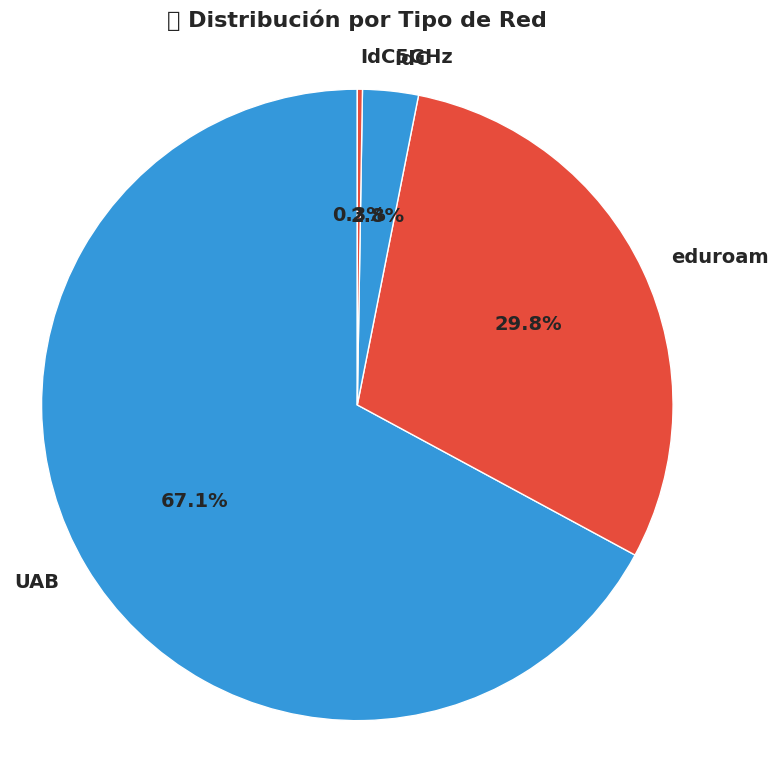


📊 Desglose por red:
   UAB: 7,728 dispositivos (67.1%)
   eduroam: 3,429 dispositivos (29.8%)
   IdC: 328 dispositivos (2.8%)
   IdC5GHz: 30 dispositivos (0.3%)


In [124]:
# Distribución por tipo de red
network_counts = df_clients['network'].value_counts()

plt.figure(figsize=(8, 8))
colors = ['#3498db', '#e74c3c']
plt.pie(network_counts.values, labels=network_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title('🌐 Distribución por Tipo de Red', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\n📊 Desglose por red:")
for network, count in network_counts.items():
    pct = (count / len(df_clients)) * 100
    print(f"   {network}: {count:,} dispositivos ({pct:.1f}%)")

### 5.5 Bandas WiFi (2.4 GHz vs 5 GHz)

In [125]:
# Distribución por banda
band_counts = df_clients['band'].value_counts().sort_index()
band_labels = {2.4: '2.4 GHz', 5: '5 GHz', 6: '6 GHz'}

plt.figure(figsize=(10, 6))
colors_band = ['#f39c12', '#9b59b6', '#1abc9c']
bars = plt.bar([band_labels.get(x, str(x)) for x in band_counts.index],
               band_counts.values, color=colors_band[:len(band_counts)], alpha=0.8)
plt.title('📻 Distribución por Banda WiFi', fontsize=16, fontweight='bold')
plt.xlabel('Banda', fontsize=12)
plt.ylabel('Número de Dispositivos', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Añadir valores encima de las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 🎯 6. Insights y Conclusiones

Basándote en las visualizaciones anteriores, responde:

**1. ¿Cuál es el AP más utilizado? ¿En qué edificio está?**

```
Tu respuesta aquí:
```

**2. ¿A qué hora hay más actividad? ¿Por qué crees que es?**

```
Tu respuesta aquí:
```

**3. ¿Qué porcentaje de dispositivos tiene señal débil?**

```
Tu respuesta aquí:
```

**4. ¿Cuál es la red más utilizada (UAB o eduroam)?**

```
Tu respuesta aquí:
```

**5. ¿Qué banda WiFi es más popular (2.4 o 5 GHz)? ¿Por qué?**

```
Tu respuesta aquí:
```

## 🚀 7. Próximos Pasos

¡Felicidades! Has completado el análisis básico. Ahora puedes:

### Ideas para Expandir tu Análisis:

1. **Cargar más datos:** Cambia `max_files=100` o `max_files=None` para todo el dataset

2. **Análisis por edificio:**
   - Extraer el código del edificio del nombre del AP (ej: AP-VET71 → VET)
   - Comparar actividad entre edificios

3. **Análisis temporal más profundo:**
   - Comparar días laborables vs fines de semana
   - Identificar patrones semanales

4. **Problemas de conectividad:**
   - Identificar APs con peor señal
   - Analizar zonas problemáticas

5. **Dashboard interactivo:**
   - Usar Plotly para gráficos interactivos
   - Crear filtros por fecha/hora/edificio

### ¿Listo para el siguiente nivel?

👉 Continúa con: **`02_intermediate_mobility.ipynb`**

---

**🏴‍☠️ UAB THE HACK! 2025 - ¡Buena suerte! 🚀**